In [1]:
import math
import elevation as eio
from pathlib import Path

In [2]:
lat, lon = 44.5451545715, 4.2165341377

def bounds_from_distance(km):
    dlat = (km/2) / 111.11
    dlon = dlat / math.cos(math.radians(lat))
    return [lon - dlon, lat - dlat, lon + dlon, lat + dlat]

bounds = bounds_from_distance(50)

In [3]:
datapath = Path.cwd()/'data/MNS/'
tiff_file = datapath/'dem.tiff'
eio.clip(bounds=bounds, output=tiff_file, product='SRTM3')

make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
make: Nothing to be done for 'download'.
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'
make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'
make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
cp SRTM3.vrt SRTM3.838ddcdcd5d74033bbc08acdabb62583.vrt
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'
make: Entering directory '/home/nicod/.cache/elevation/SRTM3'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 3.9008291696998154 44.7701568215225 4.532239105700185 44.3201523214775 SRTM3.838ddcdcd5d74033bbc08acdabb62583.vrt /media/nicod/Documents/D4G/pyronear/lidar/data/MNS/dem.tiff
rm -f SRTM3.838ddcdcd5d74033bbc08acdabb62583.vrt
make: Leaving directory '/home/nicod/.cache/elevation/SRTM3'


In [16]:
import contextily as cx

_ = cx.bounds2raster(*bounds, 'satellite.tiff', ll=True, source=cx.providers.Esri.WorldImagery)

In [17]:
import rioxarray
from rasterio.crs import CRS

crs = CRS.from_dict(proj='tmerc', ellps='WGS84', lat_0=lat, lon_0=lon) #metric CRS centered on the camera

dem = rioxarray.open_rasterio(tiff_file)
dem = dem.rio.reproject(crs)
dem = dem.rio.interpolate_na()

sat = rioxarray.open_rasterio('satellite.tiff')
sat = sat.rio.reproject(crs)
sat = sat.rio.clip_box(*dem.rio.bounds())

/home/nicod/anaconda3/envs/geo/lib/python3.11/site-packages/rioxarray/raster_array.py:1011: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_xds in self._obj.groupby(extra_dim):


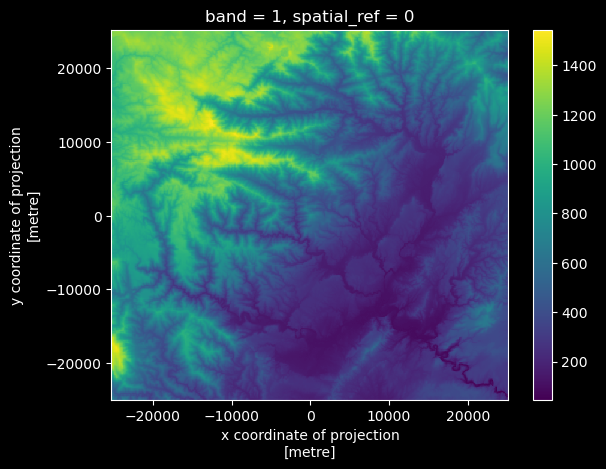

In [19]:
dem.plot()

In [38]:
tiff_file.as_posix()

'/media/nicod/Documents/D4G/pyronear/lidar/data/MNS/dem.tiff'

In [73]:
from osgeo import gdal

xyz_path = (datapath/'dem.xyz').as_posix()
ds = gdal.Open(tiff_file.as_posix())
xyz = gdal.Translate(xyz_path, ds)

In [74]:
import pandas as pd

test = pd.read_csv(xyz_path, sep=' ', names=['x', 'y', 'z'])

In [75]:
test

,x,y,z
0,3.900417,44.770417,1255
1,3.901250,44.770417,1269
2,3.902083,44.770417,1273
3,3.902917,44.770417,1267
4,3.903750,44.770417,1265
...,...,...,...
409315,4.527917,44.321250,183
409316,4.528750,44.321250,199
409317,4.529583,44.321250,216
409318,4.530417,44.321250,224


In [ ]:
from pyproj import Transformer
import numpy as np
projector = Transformer.from_crs("EPSG:4326", "EPSG:2154")

for i in range(len(test)):
    test.iloc[i] = np.array(projector.transform(test.at[i, 'y'], test.at[i,'x'])+(test.at[i,'z'],))
test


In [88]:
tcopy = test.copy()
tcopy[['x', 'z', 'y']].to_csv(xyz_path, sep=' ', header=False)